In [8]:
# Import python packages
%matplotlib inline
import katdal
import matplotlib
import os, string
import matplotlib.pyplot as plt
import numpy
import numpy as np
import pylab
import scape
from pylab import figure, plot, legend, xlabel, ylabel, ylim,xlim, subplot,title,hist
from pylab import *
import scipy as sp
from scipy import signal as sp_signal
from scipy import integrate
from datetime import datetime
import time
import katpoint
import itertools
import copy
import csv
import sys
import matplotlib.ticker as mtick
import matplotlib.backends.backend_pdf
from scipy.interpolate import interp1d

In [9]:
# Tau A
filename='/var/kat/archive2/data/MeerKATAR1/telescope_products/2016/06/21/1466504538.h5'

In [10]:
try:
    h5 = katdal.open(filename, quicklook=True)
except Exception as err_msg: raise SystemExit('An error as occured:\n%s' % err_msg)
ants = h5.ants
scan_indices = h5.scan_indices
pol = 'V'
ant = ants[0]

# Analyse track information if available

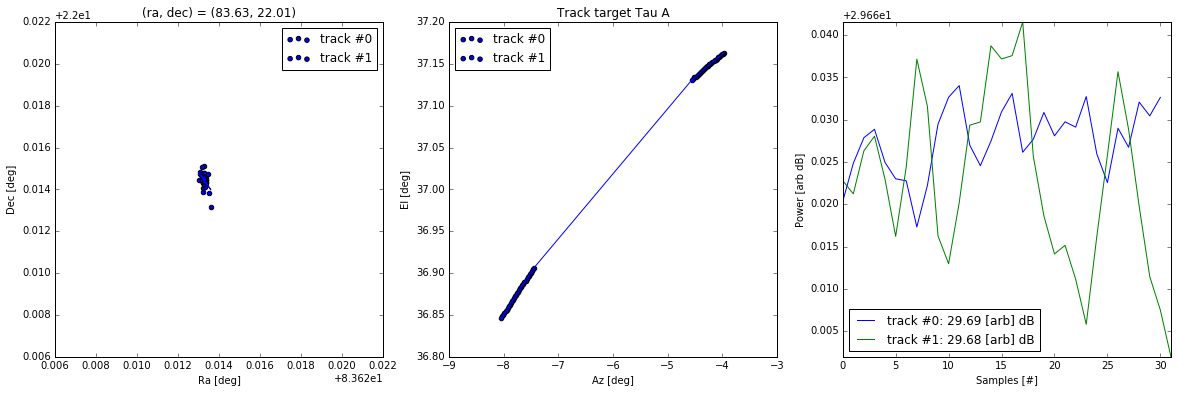

In [11]:
def get_track(h5, ant, pol, scan_indices, track_indices):
    track_data=[]
    for scan_idx in track_indices:
        h5.select(reset='T')
        h5.select(ants=ant.name, pol=pol, corrprods='auto', scans=scan_indices[scan_idx], compscans='track')
        nd_mask=h5.sensor['Antennas/%s/nd_coupler'%ant.name]
        if np.any(h5.sensor['Antennas/%s/nd_coupler'%ant.name]):
            nd_idx=np.nonzero(h5.sensor['Antennas/%s/nd_coupler'%ant.name])[0]
            if nd_idx[0]>0: nd_mask[nd_idx[0]-1]=True
            if nd_idx[-1]<len(h5.dumps): nd_mask[nd_idx[-1]+1]=True
        data={}
        data['timestamps'] = h5.timestamps[~nd_mask]
        data['track'] = h5.vis[~nd_mask,2200:2400,0]
        data['ra'] = h5.ra
        data['dec'] = h5.dec
        data['az'] = h5.az
        data['el'] = h5.el

        track_data.append(data)
    return track_data
h5.select(reset='T')
h5.select(ants=ant.name, pol=pol, corrprods='auto', scans='track', compscans='track')
track_data=[]
if h5.scan_indices:
    track_indices = h5.scan_indices
    track_data = get_track(h5, ant, pol, scan_indices, track_indices)

measured_amp = []
plt.figure(figsize=(20,6))
for track_idx in range(len(track_data)):
    measured_amp.append(np.mean(numpy.abs(track_data[track_idx]['track']), axis=1).flatten().mean())
    plt.subplot(131)
    plt.scatter(track_data[track_idx]['ra'], track_data[track_idx]['dec'], label='track #%d'%track_idx)
    plt.subplot(132)
    plt.scatter(track_data[track_idx]['az'], track_data[track_idx]['el'], label='track #%d'%track_idx)
    plt.subplot(133)
    plt.plot(10.*np.log10(np.mean(track_data[track_idx]['track'], axis=1)), label='track #%d: %.2f [arb] dB'%
                 (track_idx,
                  10.*np.log10(np.mean(numpy.abs(track_data[track_idx]['track']), axis=1).flatten().mean())))
    plt.axis('tight')
plt.subplot(131)
z = np.polyfit(numpy.vstack((track_data[0]['ra'],track_data[-1]['ra'])).flatten(),
               numpy.vstack((track_data[0]['dec'],track_data[-1]['dec'])).flatten(), 1)
f = np.poly1d(z)
plt.plot(numpy.vstack((track_data[0]['ra'],track_data[-1]['ra'])).flatten(),
         f(numpy.vstack((track_data[0]['ra'],track_data[-1]['ra'])).flatten()))
plt.legend(loc=0)
plt.title('(ra, dec) = (%.2f, %.2f)'%
          (np.mean(track_data[track_idx]['ra'], axis=1).mean(axis=0),
          np.mean(track_data[track_idx]['dec'], axis=1).mean(axis=0)))
plt.ylabel('Dec [deg]')
plt.xlabel('Ra [deg]')
plt.subplot(132)
z = np.polyfit(numpy.vstack((track_data[0]['az'],track_data[-1]['az'])).flatten(),
               numpy.vstack((track_data[0]['el'],track_data[-1]['el'])).flatten(), 2)
f = np.poly1d(z)
plt.plot(numpy.vstack((track_data[0]['az'],track_data[-1]['az'])).flatten(),
         f(numpy.vstack((track_data[0]['az'],track_data[-1]['az'])).flatten()))
plt.legend(loc=0)
plt.title('Track target %s'%h5.catalogue.targets[0].name)
plt.xlabel('Az [deg]')
plt.ylabel('El [deg]')
plt.subplot(133)
plt.legend(loc=0)
plt.ylabel('Power [arb dB]')
plt.xlabel('Samples [#]')

# Analyse drift scan information if available

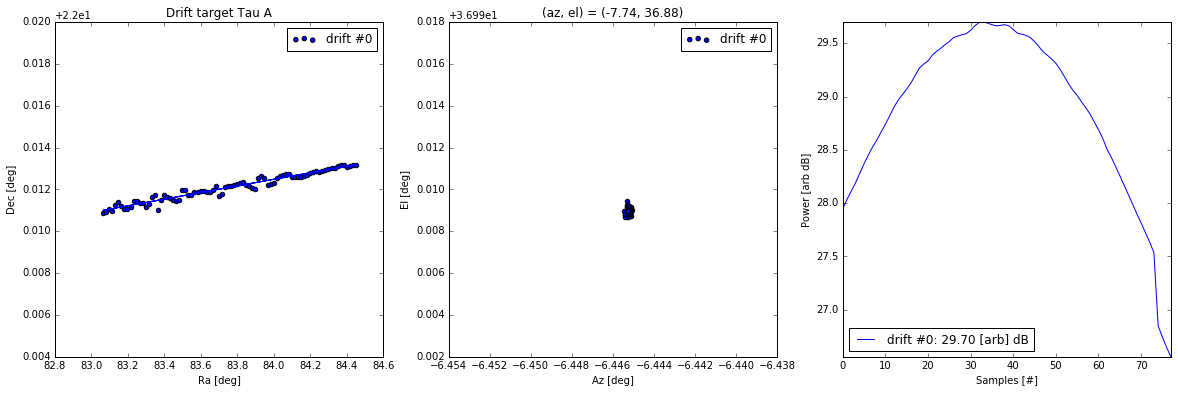

In [12]:
def get_drift(h5, ant, pol, scan_indices, drift_indices):
    drift_data=[]
    for scan_idx in drift_indices:
        h5.select(reset='T')
        h5.select(ants=ant.name, pol=pol, corrprods='auto', scans=scan_indices[scan_idx])
        nd_mask=h5.sensor['Antennas/%s/nd_coupler'%ant.name]
        if np.any(h5.sensor['Antennas/%s/nd_coupler'%ant.name]):
            nd_idx=np.nonzero(h5.sensor['Antennas/%s/nd_coupler'%ant.name])[0]
            if nd_idx[0]>0: nd_mask[nd_idx[0]-1]=True
            if nd_idx[-1]<len(h5.dumps): nd_mask[nd_idx[-1]+1]=True
        data={}
        data['timestamps'] = h5.timestamps[~nd_mask]
        data['drift'] = h5.vis[~nd_mask,2200:2400,0]
        data['ra'] = h5.ra
        data['dec'] = h5.dec
        data['az'] = h5.az
        data['el'] = h5.el
        drift_data.append(data)
    return drift_data
h5.select(reset='T')
h5.select(ants=ant.name, pol=pol, corrprods='auto', scans='track', compscans='drift')
drift_data=[]
if h5.scan_indices:
    drift_indices = h5.scan_indices
    drift_data = get_drift(h5, ant, pol, scan_indices, drift_indices)
    
plt.figure(figsize=(20,6))
for drift_idx in range(len(drift_data)):
    measured_amp.append(np.mean(numpy.abs(drift_data[drift_idx]['drift']), axis=1).flatten().max())
    plt.subplot(131)
    plt.scatter(drift_data[drift_idx]['ra'], drift_data[drift_idx]['dec'], label='drift #%d'%drift_idx)
    plt.subplot(132)
    plt.scatter(drift_data[drift_idx]['az'], drift_data[drift_idx]['el'], label='drift #%d'%drift_idx)
    plt.subplot(133)
    plt.plot(10.*np.log10(np.mean(drift_data[drift_idx]['drift'], axis=1)), label='drift #%d: %.2f [arb] dB'%
                 (drift_idx,10.*np.log10(np.mean(numpy.abs(drift_data[drift_idx]['drift']), axis=1).flatten().max())))
    plt.axis('tight')
plt.subplot(131)
z = np.polyfit(numpy.vstack((drift_data[0]['ra'],drift_data[-1]['ra'])).flatten(),
               numpy.vstack((drift_data[0]['dec'],drift_data[-1]['dec'])).flatten(), 2)
f = np.poly1d(z)
plt.plot(numpy.vstack((drift_data[0]['ra'],drift_data[-1]['ra'])).flatten(),
         f(numpy.vstack((drift_data[0]['ra'],drift_data[-1]['ra'])).flatten()))
plt.legend(loc=0)
plt.title('Drift target %s'%h5.catalogue.targets[0].name)
plt.ylabel('Dec [deg]')
plt.xlabel('Ra [deg]')
plt.subplot(132)
plt.legend(loc=0)
plt.title('(az, el) = (%.2f, %.2f)'%
          (np.mean(track_data[track_idx]['az'], axis=1).mean(axis=0),
          np.mean(track_data[track_idx]['el'], axis=1).mean(axis=0)))
plt.xlabel('Az [deg]')
plt.ylabel('El [deg]')
plt.subplot(133)
plt.legend(loc=0)
plt.ylabel('Power [arb dB]')
plt.xlabel('Samples [#]')

# Analyse raster scan information if available

(15, 1)
5:34:31.97 22:00:52.1
5:35:29.74 22:01:17.4
37:08:44.2 355:28:14.8
37.1456013105 -4.52922502451


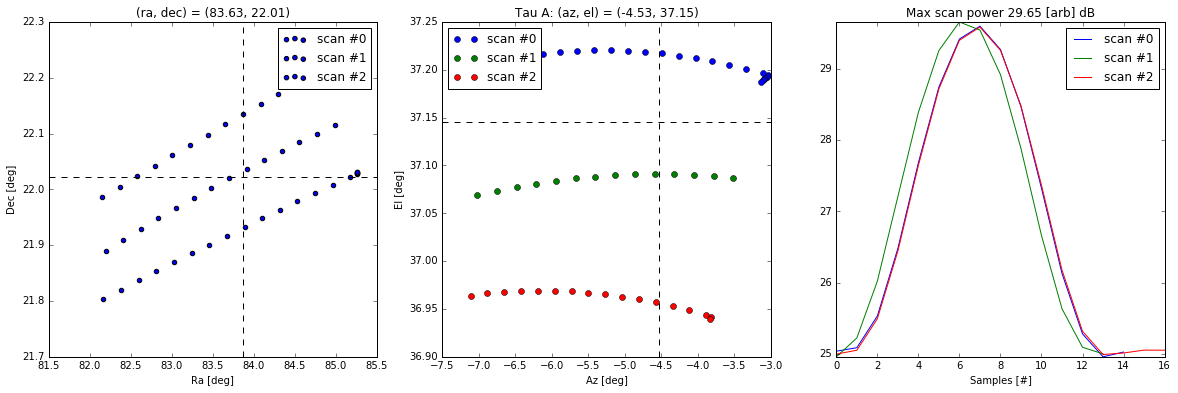

In [13]:
def get_scan(h5, ant, pol, scan_indices, raster_indices):
    raster_data=[]
    for scan_idx in raster_indices:
        h5.select(reset='T')
        h5.select(ants=ant.name, pol=pol, corrprods='auto', scans=scan_indices[scan_idx])
        nd_mask=h5.sensor['Antennas/%s/nd_coupler'%ant.name]
        if np.any(h5.sensor['Antennas/%s/nd_coupler'%ant.name]):
            nd_idx=np.nonzero(h5.sensor['Antennas/%s/nd_coupler'%ant.name])[0]
            if nd_idx[0]>0: nd_mask[nd_idx[0]-1]=True
            if nd_idx[-1]<len(h5.dumps): nd_mask[nd_idx[-1]+1]=True
        data={}
        data['timestamps'] = h5.timestamps[~nd_mask]
        data['scan'] = h5.vis[~nd_mask,2200:2400,0]
        data['ra'] = h5.ra
        data['dec'] = h5.dec
        data['az'] = h5.az
        data['el'] = h5.el
        raster_data.append(data)
    return raster_data
h5.select(reset='T')
h5.select(ants=ant.name, pol=pol, corrprods='auto', scans='scan')
raster_data=[]
if h5.scan_indices:
    raster_indices = h5.scan_indices
    raster_data = get_scan(h5, ant, pol, scan_indices, raster_indices)
print numpy.median(numpy.abs(raster_data[0]['scan']),axis=1).shape
scan_amp=[]
plt.figure(figsize=(20,6))
for raster_idx in range(len(raster_data)):
    scan_amp.append(np.mean(numpy.abs(raster_data[raster_idx]['scan']), axis=1).flatten().max())
    plt.subplot(131)
    plt.scatter(raster_data[raster_idx]['ra'], raster_data[raster_idx]['dec'], label='scan #%d'%raster_idx)
    plt.subplot(132)
    plt.plot(raster_data[raster_idx]['az'], raster_data[raster_idx]['el'], 'o', label='scan #%d'%raster_idx)
    plt.subplot(133)
    plt.plot(10.*np.log10(np.mean(raster_data[raster_idx]['scan'], axis=1)), label='scan #%d'%raster_idx)
    plt.axis('tight')

import datetime,ephem
observer = ephem.Observer()
observer.lon='21:24:38.5'
observer.lat='-30:43:17.3'
observer.elevation = 1038.0

ra=np.mean(track_data[track_idx]['ra'], axis=1).mean(axis=0)
dec=np.mean(track_data[track_idx]['dec'], axis=1).mean(axis=0)
raH = int(ra/15)
raM = int(((ra/15)-raH)*60)
raS = int(((((ra/15)-raH)*60)-raM)*60)
deg = int(dec)
decM = abs(int((dec-deg)*60))
decS = int((abs((dec-deg)*60)-decM)*60)
target = ephem.FixedBody()
target._ra = '5:34:31.97'
target._dec = '22:00:52.1'
observer.date = ephem.Date(datetime.datetime(2016, 6, 21, 10, 25, 14, 71))
target.compute(observer)
print target._ra, target._dec
print target.ra, target.dec
print target.alt, target.az
print np.rad2deg(float(target.alt)), np.rad2deg(float(target.az))-360.

measured_amp.append(numpy.max(scan_amp))
plt.subplot(131)
plt.axvline(x=np.rad2deg(float(target.ra)), color='k', linestyle='--')
plt.axhline(y=np.rad2deg(float(target.dec)), color='k', linestyle='--')
plt.legend(loc=0)
plt.title('(ra, dec) = (%.2f, %.2f)'% (ra,dec))
plt.ylabel('Dec [deg]')
plt.xlabel('Ra [deg]')
plt.subplot(132)
plt.axvline(x=(np.rad2deg(float(target.az))-360.), color='k', linestyle='--')
plt.axhline(y=np.rad2deg(float(target.alt)), color='k', linestyle='--')
plt.legend(loc=0)
plt.title('%s: (az, el) = (%.2f, %.2f)'% (h5.catalogue.targets[0].name, (np.rad2deg(float(target.az))-360.),np.rad2deg(float(target.alt))))
plt.xlabel('Az [deg]')
plt.ylabel('El [deg]')
plt.subplot(133)
plt.legend(loc=0)
plt.title('Max scan power %.2f [arb] dB'%(10.*np.log10(numpy.max(scan_amp))))
plt.xlabel('Samples [#]')

[ 29.68758392  29.68288422  29.69910431  29.65229988]


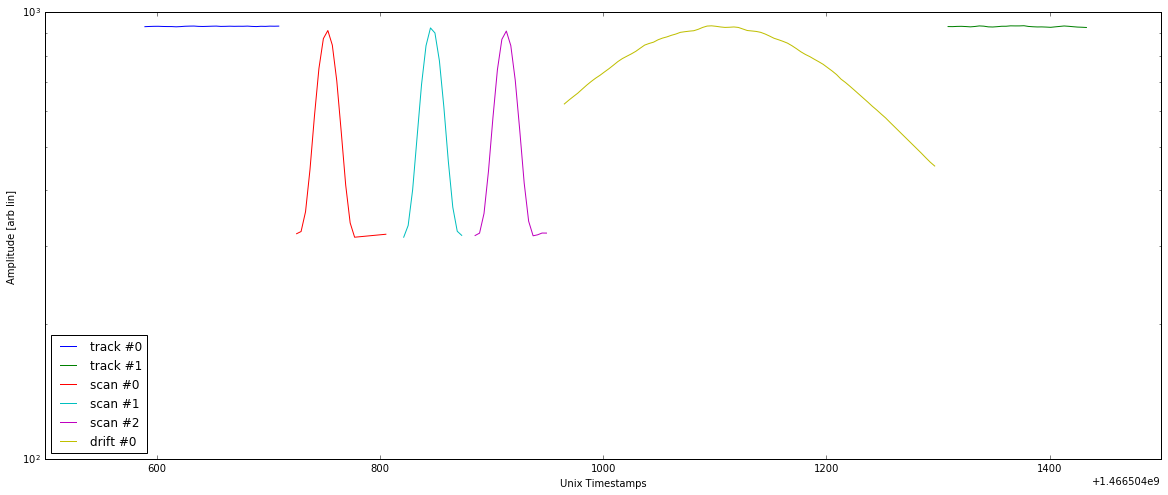

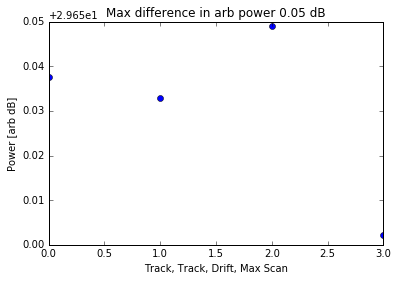

In [14]:
plt.figure(figsize=(20,8))
for track_idx in range(len(track_data)):
    plt.semilogy(track_data[track_idx]['timestamps'], np.mean(track_data[track_idx]['track'], axis=1), label='track #%d'%track_idx)
for raster_idx in range(len(raster_data)):
    plt.semilogy(raster_data[raster_idx]['timestamps'], np.mean(raster_data[raster_idx]['scan'], axis=1), label='scan #%d'%raster_idx)
for drift_idx in range(len(drift_data)):
    plt.semilogy(drift_data[drift_idx]['timestamps'], np.mean(drift_data[drift_idx]['drift'], axis=1), label='drift #%d'%drift_idx)
#plt.axis('tight')
plt.legend(loc=0)
plt.ylabel('Amplitude [arb lin]')
plt.xlabel('Unix Timestamps')

measured_amp = 10.*numpy.log10(measured_amp)
plt.figure()
plt.plot(measured_amp, 'o')
plt.ylabel('Power [arb dB]')
plt.xlabel('Track, Track, Drift, Max Scan')
plt.title('Max difference in arb power %.2f dB'%
          (measured_amp.max()-measured_amp.min()))
print measured_amp